In [1]:
import os
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [921 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:14 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [51.8 kB]
Ge

In [31]:
#Import dependencies
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Import Keras Dependencies
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, LeakyReLU, PReLU

In [3]:
 # Import findspark and initialize.
import findspark
findspark.init()

In [4]:
 # Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("weatherclassification").getOrCreate()

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [5]:
# Load in data
from pyspark import SparkFiles
url = 'https://weatherclassification.s3.amazonaws.com/weather_classification_data.csv'
spark.sparkContext.addFile(url)
print(SparkFiles.getRootDirectory())

spark_df = spark.read.csv(SparkFiles.get("weather_classification_data.csv"), sep=",", header=True, inferSchema=True)
spark_df.show()

/tmp/spark-6ed61566-d6ee-4228-9151-6afadf0c95f2/userFiles-08280cde-9dd4-454e-a1f6-56d14dfd1df5
+-----------+--------+----------+-----------------+-------------+--------------------+--------+------+---------------+--------+------------+
|Temperature|Humidity|Wind Speed|Precipitation (%)|  Cloud Cover|Atmospheric Pressure|UV Index|Season|Visibility (km)|Location|Weather Type|
+-----------+--------+----------+-----------------+-------------+--------------------+--------+------+---------------+--------+------------+
|         14|      73|       9.5|               82|partly cloudy|             1010.82|       2|Winter|            3.5|  inland|       Rainy|
|         39|      96|       8.5|               71|partly cloudy|             1011.43|       7|Spring|           10.0|  inland|      Cloudy|
|         30|      64|       7.0|               16|        clear|             1018.72|       5|Spring|            5.5|mountain|       Sunny|
|         38|      83|       1.5|               82|        

In [37]:
# Convert PySpark DataFrame to pandas DataFrame
weather_df = spark_df.toPandas()
weather_df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14,73,9.5,82,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39,96,8.5,71,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30,64,7.0,16,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38,83,1.5,82,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27,74,17.0,66,overcast,990.67,1,Winter,2.5,mountain,Rainy


In [38]:
# Check for missing values
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13200 non-null  int32  
 1   Humidity              13200 non-null  int32  
 2   Wind Speed            13200 non-null  float64
 3   Precipitation (%)     13200 non-null  int32  
 4   Cloud Cover           13200 non-null  object 
 5   Atmospheric Pressure  13200 non-null  float64
 6   UV Index              13200 non-null  int32  
 7   Season                13200 non-null  object 
 8   Visibility (km)       13200 non-null  float64
 9   Location              13200 non-null  object 
 10  Weather Type          13200 non-null  object 
dtypes: float64(3), int32(4), object(4)
memory usage: 928.2+ KB


In [39]:
# Determine number of unique weather types
weather_df['Weather Type'].unique()

array(['Rainy', 'Cloudy', 'Sunny', 'Snowy'], dtype=object)

In [40]:
# Determine each weather type value counts
weather_df['Weather Type'].value_counts()

,count
Weather Type,
Rainy,3300
Cloudy,3300
Sunny,3300
Snowy,3300


In [41]:
#Create weather data remove seasons
weather_data_no_type = weather_df.drop('Weather Type', axis=1)

In [42]:
# Convert categorical data to numeric with 'get_dummies'
weather_data_no_type = pd.get_dummies(weather_data_no_type).astype(int)
weather_data_no_type.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Cloud Cover_clear,Cloud Cover_cloudy,Cloud Cover_overcast,Cloud Cover_partly cloudy,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Location_coastal,Location_inland,Location_mountain
0,14,73,9,82,1010,2,3,0,0,0,1,0,0,0,1,0,1,0
1,39,96,8,71,1011,7,10,0,0,0,1,0,1,0,0,0,1,0
2,30,64,7,16,1018,5,5,1,0,0,0,0,1,0,0,0,0,1
3,38,83,1,82,1026,7,1,1,0,0,0,0,1,0,0,1,0,0
4,27,74,17,66,990,1,2,0,0,1,0,0,0,0,1,0,0,1


In [43]:
# Split our preprocessed data into our features and target arrays
X = weather_data_no_type
y = weather_df['Weather Type']

# Use LabelEncoder to convert categorical season labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = 4
y_one_hot = to_categorical(y_encoded, num_classes)

encoded_labels = label_encoder.classes_
encoded_labels = label_encoder.transform(label_encoder.classes_)
label_mapping = dict(zip(encoded_labels, label_encoder.classes_))
print(f"Labels: {label_mapping}")

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, random_state=1)

Labels: {0: 'Cloudy', 1: 'Rainy', 2: 'Snowy', 3: 'Sunny'}


In [44]:
# Determine Data Shape
print('Data Shapes')
print(f'Training Data: {X_train.shape}')
print(f'Training Labels: {y_train.shape}')
print(f'Training Data: {X_test.shape}')
print(f'Training Labels: {y_test.shape}')

Data Shapes
Training Data: (9900, 18)
Training Labels: (9900, 4)
Training Data: (3300, 18)
Training Labels: (3300, 4)


In [45]:
# Normalize Data
scaler = MinMaxScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
# Create function for model creation
def gen_model(units, activation_functions, input_dim, optimizer):
  # Define the deep learning model
  nn_model = tf.keras.models.Sequential()
  nn_model.add(tf.keras.Input(shape=(input_dim,)))
  for i in range(len(units)):
    nn_model.add(tf.keras.layers.Dense(units=units[i], activation=activation_functions[i]))
  nn_model.add(tf.keras.layers.Dense(units=4, activation="softmax"))

  # Compile the Sequential model together and customize metrics
  nn_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  return nn_model

In [51]:
# Model Optimizer Adam
units = [64, 32, 16, 8]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_adam = gen_model(units, activations_funcs, 18, 'adam')


# Train the model
fit_model = nn_model_adam.fit(X_train, y_train, epochs=50)

# Evaluate the model using the test data
nn_model_adam_losses = []
model_loss, model_accuracy = nn_model_adam.evaluate(X_test,y_test,verbose=2)

print(f"Model Optimizer Adam Loss: {model_loss}, Accuracy: {model_accuracy}")


Epoch 1/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4834 - loss: 1.1053
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8648 - loss: 0.4200
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8841 - loss: 0.3460
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8938 - loss: 0.3075
Epoch 5/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8976 - loss: 0.2884
Epoch 6/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8978 - loss: 0.2840
Epoch 7/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9037 - loss: 0.2665
Epoch 8/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9060 - loss: 0.2585
Epoch 9/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9021 - loss: 0.2508
Epoch 10/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9073 - loss: 0.2494
Epoch 11/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8986 - loss: 0.2542
Epoch 12/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [52]:
# Make predictions using testing data
predictions = nn_model_adam.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model Optimizer Adam')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model Optimizer Adam ")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix Model Optimizer Adam
[[766  31  24  21]
 [ 63 730  42  11]
 [ 24   8 773  15]
 [ 42  13  23 714]]
Classification Report Model Optimizer Adam 
              precision    recall  f1-score   support

      Cloudy       0.86      0.91      0.88       842
       Rainy       0.93      0.86      0.90       846
       Snowy       0.90      0.94      0.92       820
       Sunny       0.94      0.90      0.92       792

    accuracy                           0.90      3300
   macro avg       0.91      0.90      0.90      3300
weighted avg       0.91      0.90      0.90      3300



In [53]:
nn_model_adam_losses = fit_model.history['loss']
nn_model_adam_accuracy = fit_model.history['accuracy']

In [54]:
# Model Optimizers SDG
units = [64, 32, 16, 8]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_SDG = gen_model(units, activations_funcs, 18, 'SGD')


# Train the model
fit_model = nn_model_SDG.fit(X_train, y_train, epochs=50)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model_SDG.evaluate(X_test,y_test,verbose=2)
print(f"# Model Optimizers SDG Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3760 - loss: 1.3092
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6293 - loss: 1.0886
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6887 - loss: 0.9484
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7022 - loss: 0.8428
Epoch 5/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7660 - loss: 0.7817
Epoch 6/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8114 - loss: 0.7459
Epoch 7/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8361 - loss: 0.6914
Epoch 8/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8470 - loss: 0.6455
Epoch 9/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8589 - loss: 0.5869
Epoch 10/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8657 - loss: 0.5409
Epoch 11/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8600 - loss: 0.5085
Epoch 12/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

In [55]:
# Make predictions using testing data
predictions = nn_model_SDG.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix # Model Optimizers SDG')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report # Model Optimizers SDG")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix # Model Optimizers SDG
[[754  48  27  13]
 [ 52 734  43  17]
 [ 18  18 766  18]
 [ 57  17  12 706]]
Classification Report # Model Optimizers SDG
              precision    recall  f1-score   support

      Cloudy       0.86      0.90      0.88       842
       Rainy       0.90      0.87      0.88       846
       Snowy       0.90      0.93      0.92       820
       Sunny       0.94      0.89      0.91       792

    accuracy                           0.90      3300
   macro avg       0.90      0.90      0.90      3300
weighted avg       0.90      0.90      0.90      3300



In [56]:
nn_model_SDG_losses = fit_model.history['loss']
nn_model_SDG_accuracy = fit_model.history['accuracy']

In [57]:
# Model Optimizer Adagrad
units = [64, 32, 16, 8]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_adagrad = gen_model(units, activations_funcs, 18, 'Adagrad')


# Train the model
fit_model = nn_model_adagrad.fit(X_train, y_train, epochs=50)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model_adagrad.evaluate(X_test,y_test,verbose=2)
print(f"Model Optimizer Adagrad Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2108 - loss: 1.3860
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2759 - loss: 1.3597
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3074 - loss: 1.3360
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3129 - loss: 1.3140
Epoch 5/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3309 - loss: 1.2794
Epoch 6/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3375 - loss: 1.2498
Epoch 7/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3488 - loss: 1.2207
Epoch 8/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3650 - loss: 1.2025
Epoch 9/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3855 - loss: 1.1813
Epoch 10/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5019 - loss: 1.1493
Epoch 11/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5855 - loss: 1.1298
Epoch 12/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

In [58]:
# Make predictions using testing data
predictions = nn_model_adagrad.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model Optimizer Adagrad')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model Optimizer Adagrad")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix Model Optimizer Adagrad
[[568 132  81  61]
 [ 67 628 128  23]
 [ 25  19 755  21]
 [ 51  29   5 707]]
Classification Report Model Optimizer Adagrad
              precision    recall  f1-score   support

      Cloudy       0.80      0.67      0.73       842
       Rainy       0.78      0.74      0.76       846
       Snowy       0.78      0.92      0.84       820
       Sunny       0.87      0.89      0.88       792

    accuracy                           0.81      3300
   macro avg       0.81      0.81      0.80      3300
weighted avg       0.81      0.81      0.80      3300



In [59]:
nn_model_adagrad_losses = fit_model.history['loss']
nn_model_adagrad_accuracy = fit_model.history['accuracy']

In [60]:
# Model Optimizer RMSProp
units = [64, 32, 16, 8]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_RMSprop = gen_model(units, activations_funcs, 18, 'RMSProp')


# Train the model
fit_model = nn_model_RMSprop.fit(X_train, y_train, epochs=50)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model_RMSprop.evaluate(X_test,y_test,verbose=2)
print(f"Model Optimizer RMSProp Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6210 - loss: 0.9916
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8633 - loss: 0.4491
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8731 - loss: 0.3842
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8854 - loss: 0.3535
Epoch 5/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8930 - loss: 0.3131
Epoch 6/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8972 - loss: 0.2987
Epoch 7/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8990 - loss: 0.2949
Epoch 8/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8981 - loss: 0.2803
Epoch 9/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8991 - loss: 0.2698
Epoch 10/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8965 - loss: 0.2739
Epoch 11/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9041 - loss: 0.2645
Epoch 12/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [61]:
# Make predictions using testing data
predictions = nn_model_RMSprop.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model Optimizer RMSProp')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model Optimizer RMSProp")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix Model Optimizer RMSProp
[[758  41  23  20]
 [ 54 745  32  15]
 [ 18  19 769  14]
 [ 48  19  18 707]]
Classification Report Model Optimizer RMSProp
              precision    recall  f1-score   support

      Cloudy       0.86      0.90      0.88       842
       Rainy       0.90      0.88      0.89       846
       Snowy       0.91      0.94      0.93       820
       Sunny       0.94      0.89      0.91       792

    accuracy                           0.90      3300
   macro avg       0.90      0.90      0.90      3300
weighted avg       0.90      0.90      0.90      3300



In [62]:
nn_model_RMSprop_losses = fit_model.history['loss']
nn_model_RMSprop_accuracy = fit_model.history['accuracy']

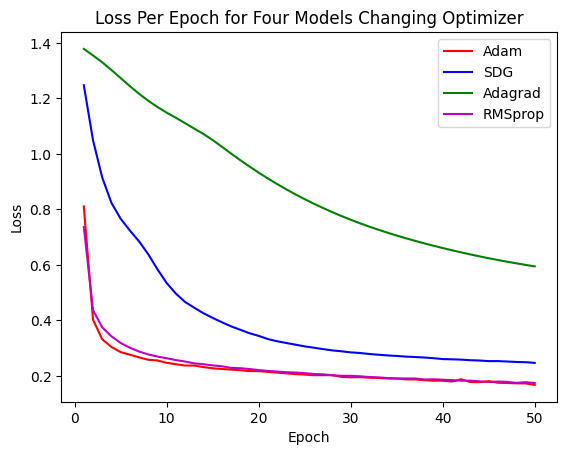

In [63]:
# Plot losses for each optimizer

epochs = range(1, len(nn_model_adam_losses) + 1)

plt.plot(epochs, nn_model_adam_losses, 'r', label = 'Adam')
plt.plot(epochs, nn_model_SDG_losses, 'b', label = 'SDG')
plt.plot(epochs, nn_model_adagrad_losses, 'g', label = 'Adagrad')
plt.plot(epochs, nn_model_RMSprop_losses, 'm', label = 'RMSprop')

plt.title('Loss Per Epoch for Four Models Changing Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

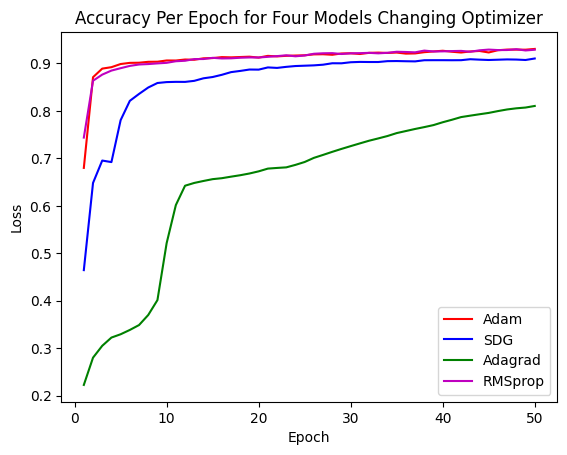

In [64]:
# Plot accuracy for each optimizer

epochs = range(1, len(nn_model_adam_accuracy) + 1)

plt.plot(epochs, nn_model_adam_accuracy, 'r', label = 'Adam')
plt.plot(epochs, nn_model_SDG_accuracy, 'b', label = 'SDG')
plt.plot(epochs, nn_model_adagrad_accuracy, 'g', label = 'Adagrad')
plt.plot(epochs, nn_model_RMSprop_accuracy, 'm', label = 'RMSprop')

plt.title('Accuracy Per Epoch for Four Models Changing Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [65]:
# Model Activation Relu
units = units = [64, 32, 16, 8]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_relu = gen_model(units, activations_funcs, 18, 'adam')


# Train the model
fit_model = nn_model_relu.fit(X_train, y_train, epochs=50)

# Evaluate the model using the test data
nn_model_relu_losses = []
model_loss, model_accuracy = nn_model_relu.evaluate(X_test,y_test,verbose=2)

print(f"Model Activation ReLU Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6434 - loss: 0.9927
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8577 - loss: 0.4509
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8856 - loss: 0.3453
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8900 - loss: 0.3237
Epoch 5/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8940 - loss: 0.2939
Epoch 6/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8994 - loss: 0.2787
Epoch 7/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9079 - loss: 0.2584
Epoch 8/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9071 - loss: 0.2495
Epoch 9/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9043 - loss: 0.2509
Epoch 10/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9075 - loss: 0.2380
Epoch 11/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9118 - loss: 0.2269
Epoch 12/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [66]:
# Make predictions using testing data
predictions = nn_model_relu.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model Activation ReLU')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model Activation ReLU")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix Model Activation ReLU
[[759  37  11  35]
 [ 46 749  19  32]
 [ 26  13 758  23]
 [ 47  15  12 718]]
Classification Report Model Activation ReLU
              precision    recall  f1-score   support

      Cloudy       0.86      0.90      0.88       842
       Rainy       0.92      0.89      0.90       846
       Snowy       0.95      0.92      0.94       820
       Sunny       0.89      0.91      0.90       792

    accuracy                           0.90      3300
   macro avg       0.91      0.90      0.90      3300
weighted avg       0.91      0.90      0.90      3300



In [67]:
nn_model_relu_losses = fit_model.history['loss']
nn_model_relu_accuracy = fit_model.history['accuracy']

In [68]:
# Model Activation LeakyReLU
units = [64, 32, 16, 8]
activations_funcs = [LeakyReLU(alpha=0.01), LeakyReLU(alpha=0.01), LeakyReLU(alpha=0.01), LeakyReLU(alpha=0.01)]
nn_model_leakyrelu = gen_model(units, activations_funcs, 18, 'adam')


# Train the model
fit_model = nn_model_leakyrelu.fit(X_train, y_train, epochs=50)

# Evaluate the model using the test data
nn_model_leakyrelu_losses = []
model_loss, model_accuracy = nn_model_leakyrelu.evaluate(X_test,y_test,verbose=2)

print(f"Model Activation LeakyReLU Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


310/310 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6539 - loss: 0.9620
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8587 - loss: 0.4600
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8831 - loss: 0.3650
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8851 - loss: 0.3297
Epoch 5/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8921 - loss: 0.3002
Epoch 6/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8918 - loss: 0.2931
Epoch 7/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8980 - loss: 0.2771
Epoch 8/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9024 - loss: 0.2607
Epoch 9/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9072 - loss: 0.2449
Epoch 10/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9070 - loss: 0.2465
Epoch 11/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9101 - loss: 0.2327
Epoch 12/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

In [69]:
# Make predictions using testing data
predictions = nn_model_leakyrelu.predict(X_test)

# Convert one-hot encoded values to categorical labels
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model Activation LeakyReLU')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model Activation LeakyReLU")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix Model Activation LeakyReLU
[[752  42  19  29]
 [ 49 746  29  22]
 [ 17  22 764  17]
 [ 40  16  20 716]]
Classification Report Model Activation LeakyReLU
              precision    recall  f1-score   support

      Cloudy       0.88      0.89      0.88       842
       Rainy       0.90      0.88      0.89       846
       Snowy       0.92      0.93      0.92       820
       Sunny       0.91      0.90      0.91       792

    accuracy                           0.90      3300
   macro avg       0.90      0.90      0.90      3300
weighted avg       0.90      0.90      0.90      3300



In [70]:
nn_model_leakyrelu_losses = fit_model.history['loss']
nn_model_leakyrelu_accuracy = fit_model.history['accuracy']

In [71]:
# Model Activation PReLU
units = [64, 32, 16, 8]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_prelu = gen_model(units, activations_funcs, 18, 'adam')


# Train the model
fit_model = nn_model_prelu.fit(X_train, y_train, epochs=50)

# Evaluate the model using the test data
nn_model_prelu_losses = []
model_loss, model_accuracy = nn_model_prelu.evaluate(X_test,y_test,verbose=2)

print(f"Model Activation PReLU Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5916 - loss: 1.0186
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8616 - loss: 0.4259
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8790 - loss: 0.3660
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8875 - loss: 0.3217
Epoch 5/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8936 - loss: 0.3031
Epoch 6/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8933 - loss: 0.2830
Epoch 7/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9002 - loss: 0.2701
Epoch 8/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9054 - loss: 0.2498
Epoch 9/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9072 - loss: 0.2434
Epoch 10/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9001 - loss: 0.2546
Epoch 11/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9047 - loss: 0.2434
Epoch 12/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [72]:
# Make predictions using testing data
predictions = nn_model_prelu.predict(X_test)

# Convert one-hot encoded values to categorical labels
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model Activation PReLU')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model Activation PReLU")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix Model Activation PReLU
[[743  24  19  56]
 [ 40 739  37  30]
 [ 16   6 770  28]
 [ 28   5  17 742]]
Classification Report Model Activation PReLU
              precision    recall  f1-score   support

      Cloudy       0.90      0.88      0.89       842
       Rainy       0.95      0.87      0.91       846
       Snowy       0.91      0.94      0.93       820
       Sunny       0.87      0.94      0.90       792

    accuracy                           0.91      3300
   macro avg       0.91      0.91      0.91      3300
weighted avg       0.91      0.91      0.91      3300



In [73]:
nn_model_prelu_losses = fit_model.history['loss']
nn_model_prelu_accuracy = fit_model.history['accuracy']

In [74]:
# Model Activation Swish
def swish(x):
    return x * tf.sigmoid(x)

units = [64, 32, 16, 8]
activations_funcs = [swish, swish, swish, swish]
nn_model_swish = gen_model(units, activations_funcs, 18, 'adam')


# Train the model
fit_model = nn_model_swish.fit(X_train, y_train, epochs=50)

# Evaluate the model using the test data
nn_model_swish_losses = []
model_loss, model_accuracy = nn_model_swish.evaluate(X_test,y_test,verbose=2)

print(f"Model Activation Swish Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6087 - loss: 0.9784
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8707 - loss: 0.4333
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8872 - loss: 0.3595
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8821 - loss: 0.3427
Epoch 5/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8937 - loss: 0.2970
Epoch 6/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8916 - loss: 0.2980
Epoch 7/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8997 - loss: 0.2781
Epoch 8/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8999 - loss: 0.2726
Epoch 9/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9087 - loss: 0.2557
Epoch 10/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8985 - loss: 0.2788
Epoch 11/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9084 - loss: 0.2577
Epoch 12/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [75]:
# Make predictions using testing data
predictions = nn_model_swish.predict(X_test)

# Convert one-hot encoded values to categorical labels
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model Activation Swish')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model Activation Swish")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix Model Activation Swish
[[762  41  19  20]
 [ 51 750  29  16]
 [ 25  12 767  16]
 [ 44  10  22 716]]
Classification Report Model Activation Swish
              precision    recall  f1-score   support

      Cloudy       0.86      0.90      0.88       842
       Rainy       0.92      0.89      0.90       846
       Snowy       0.92      0.94      0.93       820
       Sunny       0.93      0.90      0.92       792

    accuracy                           0.91      3300
   macro avg       0.91      0.91      0.91      3300
weighted avg       0.91      0.91      0.91      3300



In [76]:
nn_model_swish_losses = fit_model.history['loss']
nn_model_swish_accuracy = fit_model.history['accuracy']

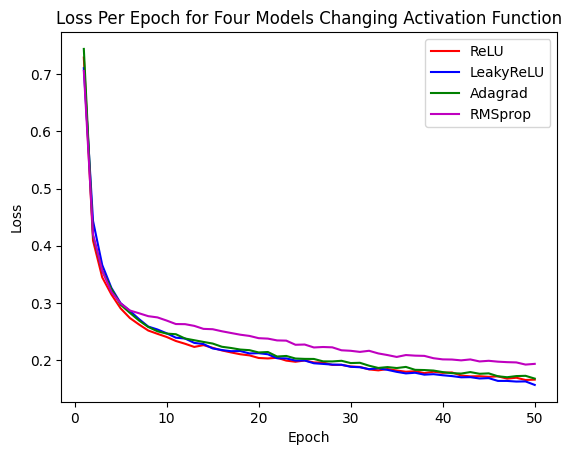

In [80]:
# Plot losses for each activation function

epochs = range(1, len(nn_model_relu_losses) + 1)

plt.plot(epochs, nn_model_relu_losses, 'r', label = 'ReLU')
plt.plot(epochs, nn_model_leakyrelu_losses, 'b', label = 'LeakyReLU')
plt.plot(epochs, nn_model_prelu_losses, 'g', label = 'Adagrad')
plt.plot(epochs, nn_model_swish_losses, 'm', label = 'RMSprop')

plt.title('Loss Per Epoch for Four Models Changing Activation Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

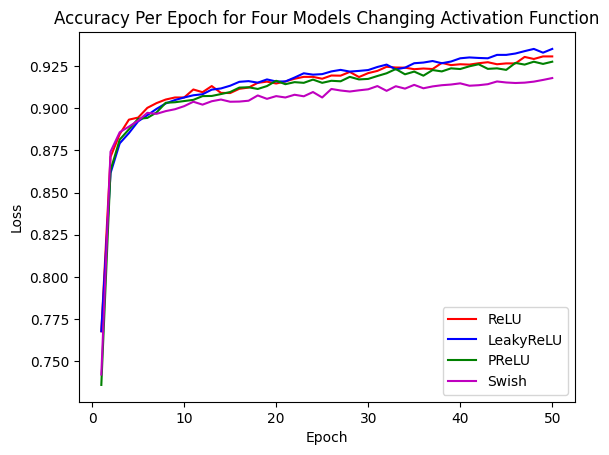

In [81]:
# Plot accuracy for each activation function

epochs = range(1, len(nn_model_relu_accuracy) + 1)

plt.plot(epochs, nn_model_relu_accuracy, 'r', label = 'ReLU')
plt.plot(epochs, nn_model_leakyrelu_accuracy, 'b', label = 'LeakyReLU')
plt.plot(epochs, nn_model_prelu_accuracy, 'g', label = 'PReLU')
plt.plot(epochs, nn_model_swish_accuracy, 'm', label = 'Swish')

plt.title('Accuracy Per Epoch for Four Models Changing Activation Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()